Вступ до комп’ютерного зору
Лабораторна робота No4
КПI iм. Iгоря Сiкорського
Листопад 2023

1 Видалення шуму
1.1 Мета
Метою цiєї лабораторної роботи є отримання навичок роботи з методами
видалення шуму з зображень.
1.2 Завдання
Виконати наступнi кроки:
1. Обрати декiлька (3+) зображень, без вираженого шуму.
2. Для кожного зображення додати наступнi типи шуму:
• Salt-Pepper (Iмпульсний шум)
• Gaussian noise (Нормальний шум)
3. Для кожного зображення застосувати наступнi методи видалення шу-
му:
• Box average (згладжування коробкою :D)
• Медiана
• Зважена медiана
4. Порiвняти результати, та зробити висновки.
5. (Опцiонально, +5 балiв) Виконати фiльтрацiю у HSV представленi, та
порiвняти результат з фiльтрацiєю в RGB.
1.3 Вимоги до виконання

• Дозволяється використання стороннiх модулiв лише для генерацiї шу-
му (Також додам .py файл готовими методами генерацiї шуму).

• Використовуйте вiртуальнi середовища (venv).
• Необхiднi для вашого коду модулi зберiгайте у файл “requirements.txt”,
та додавайте його на github разом с кодом.
• Код, оригiнальнi фото та отриманi результати залити на свiй github

• У classroom додати тiльки код та результати (для звiтностi), та поси-
лання на github.


In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import os

from numba import njit
from numba_progress import ProgressBar

In [2]:

# @njit(nogil=True)
def sp_noise_gray(image, prob=0.03):
    '''
    Add salt and pepper noise to a gray image [0,255]
    
    image: Numpy 2D array
    prob: Probability of the noise
    returns: Numpy 2D array
    '''    
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                image[i,j] = 0
            elif rdn > thres:
                image[i,j] = 255
    return image

# @njit(nogil=True)
def sp_noise_color(image, prob=0.03, white=[255,255,255], black=[0,0,0]):
    '''
    Add salt and pepper noise to a color image
    
    image: Numpy 2D array
    prob: Probability of the noise
    returns: Numpy 2D array
    '''    
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                image[i,j,:] = black
            elif rdn > thres:
                image[i,j,:] = white
    return image

In [3]:
# @njit(nogil=True)
def norm_noise_gray(image, mean=0, var=0.1, a=0.5):
    '''
    Add gaussian noise to gray image 
    
    image: Numpy 2D array
    mean: scalar
    vat: scalar
    returns: Numpy 2D array
    '''    
    sigma = var**0.5
    
    row,col= image.shape[:2]
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = a*image + (1-a)*gauss

    noisy = noisy-np.min(noisy)
    noisy = 255*(noisy/np.max(noisy))
    
    return noisy #.astype(np.uint8)

# @njit(nogil=True)
def norm_noise_color(image, mean=0, var=0.1, a=0.5):
    '''
    Add gaussian noise to color image 
    
    image: Numpy 2D array
    mean: scalar - mean
    var: scalar - variance
    a: scalar [0-1] - alpha blend
    returns: Numpy 2D array
    '''    
    sigma = var**0.5
    
    row,col,ch= image.shape[:3]
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = a*image + (1-a)*gauss

    noisy = noisy-np.min(noisy)
    noisy = 255*(noisy/np.max(noisy))
    
    return noisy #.astype(np.uint8)

In [4]:
@njit(nogil=True)
def box_average_color(image):
    '''
    Removes noise from color image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width, channels = image.shape
   
    height_fl, width_fl = (8, 8)
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for channel in range(channels):
        for row in range(height_limit, height - height_limit):
            row_start = row - height_limit
            row_finish = row + 2
            for col in range(width_limit, width - width_limit):
                res_image[row, col, channel] = np.mean(image[row_start:row_finish, col - width_limit:col + 2, channel])
    # print(res_image)
    return res_image

@njit(nogil=True)
def box_average_gray(image):
    '''
    Removes noise from gray image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width = image.shape
   
    height_fl, width_fl = (8, 8)
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for row in range(height_limit, height - height_limit):
        row_start = row - height_limit
        row_finish = row + 2
        for col in range(width_limit, width - width_limit):
            res_image[row, col] = np.mean(image[row_start:row_finish, col - width_limit:col + 2])
    return res_image

In [5]:

@njit(nogil=True)
def median_color(image):
    '''
    Removes noise from color image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width, channels = image.shape
   
    height_fl, width_fl = (8, 8)
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for channel in range(channels):
        for row in range(height_limit, height - height_limit):
            row_start = row - height_limit
            row_finish = row + 2
            for col in range(width_limit, width - width_limit):
                res_image[row, col, channel] = np.median(image[row_start:row_finish, col - width_limit:col + 2, channel])
    return res_image

@njit(nogil=True)
def median_gray(image):
    '''
    Removes noise from gray image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width = image.shape
   
    height_fl, width_fl = (3, 3)
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for row in range(height_limit, height - height_limit):
        row_start = row - height_limit
        row_finish = row + 2
        for col in range(width_limit, width - width_limit):
            res_image[row, col] = np.median(image[row_start:row_finish, col - width_limit:col + 2])
    return res_image

In [6]:
@njit(nogil=True)
def scale(filtered_ar1):
    maximum = np.max(filtered_ar1)
    minimum = np.min(filtered_ar1)
    filtered_ar1 = (255*(filtered_ar1 - minimum)/maximum).astype(np.uint8)#np.ptp(filtered_ar1)
    return filtered_ar1

@njit(nogil=True)
def weight_median_color(image):
    '''
    Removes noise from color image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    m_filter = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])*1/16
    # print(m_filter)
    
    height, width, channels = image.shape
    
    height_fl, width_fl = m_filter.shape
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for channel in range(channels):
        for row in range(height_limit, height - height_limit):
            row_start = row - height_limit
            row_finish = row + 2
            for col in range(width_limit, width - width_limit):
                res_image[row, col, channel] = np.median(image[row_start:row_finish, col - width_limit:col + 2, channel]*m_filter)
    return scale(res_image)

@njit(nogil=True)
def weight_median_gray(image):
    '''
    Removes noise from gray image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    m_filter = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])*1/16
    
    height, width = image.shape
    
    height_fl, width_fl = m_filter.shape
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for row in range(height_limit, height - height_limit):
        row_start = row - height_limit
        row_finish = row + 2
        for col in range(width_limit, width - width_limit):
            res_image[row, col] = np.median(image[row_start:row_finish, col - width_limit:col + 2]*m_filter)
    return scale(res_image)

  0%|                                                                                           | 0/34 [00:00<…

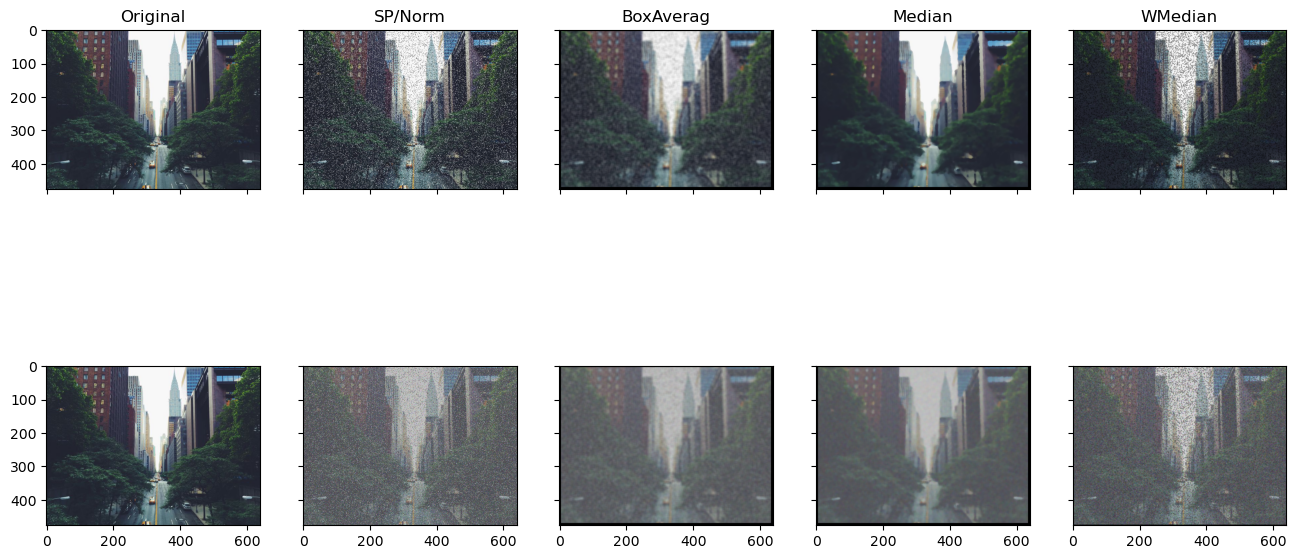

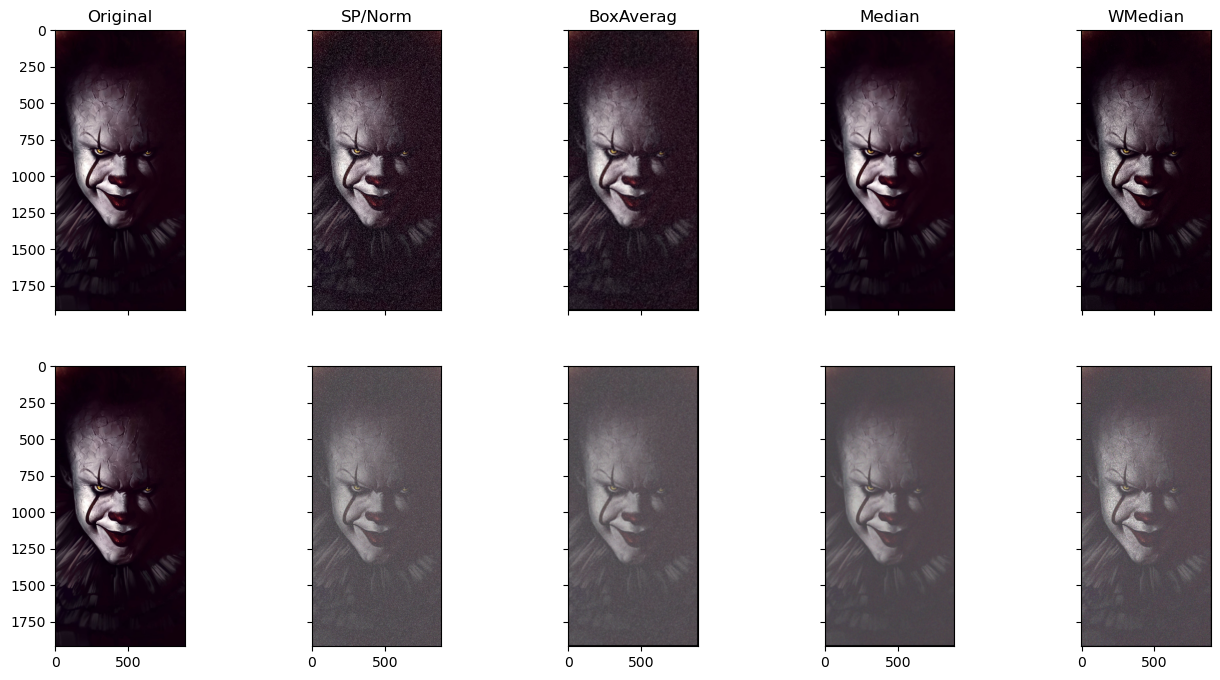

In [7]:
try:
    os.listdir('photos\\')
    if not os.path.exists('results\\'):
        os.mkdir('results\\')
except FileNotFoundError:
    os.mkdir('photos\\')
    if not os.path.exists('results\\'):
        os.mkdir('results\\')

with ProgressBar(total=17*len(os.listdir('photos\\'))) as progress:
    for item in os.listdir('photos\\'):
        img = Image.open('photos\\'+item)
        image = np.array(img)#, 0)
        # print(image.shape)
        if len(image.shape) >= 3:
            sp_noise_img = sp_noise_color(image,0.07)
            progress.update(1)
            norm_noise_img = norm_noise_color(image, mean=0, var=10, a=0.1)
            progress.update(1)
            sp_noise_img_box = box_average_color(sp_noise_img)
            progress.update(1)
            sp_noise_img_med = median_color(sp_noise_img)
            progress.update(1)
            sp_noise_img_wmed = weight_median_color(sp_noise_img)
            progress.update(1)
            norm_noise_img_box = box_average_color(norm_noise_img)
            progress.update(1)
            norm_noise_img_med = median_color(norm_noise_img)
            progress.update(1)
            norm_noise_img_wmed = weight_median_color(norm_noise_img)
            progress.update(1)
        else:
            sp_noise_img = sp_noise_gray(image,0.07)
            progress.update(1)
            norm_noise_img = norm_noise_gray(image, mean=0, var=10, a=0.1)
            progress.update(1)
            sp_noise_img_box = box_average_gray(sp_noise_img)
            progress.update(1)
            sp_noise_img_med = median_gray(sp_noise_img)
            progress.update(1)
            sp_noise_img_wmed = weight_median_gray(sp_noise_img)
            progress.update(1)
            norm_noise_img_box = box_average_gray(norm_noise_img)
            progress.update(1)
            norm_noise_img_med = median_gray(norm_noise_img)
            progress.update(1)
            norm_noise_img_wmed = weight_median_gray(norm_noise_img)
            progress.update(1)
        
        # print((sp_noise_img_box == sp_noise_img_med).all())
        
        # print([sp_noise_img_box == sp_img])
        
        sp_img = Image.fromarray(sp_noise_img)#.astype(np.uint8))
        progress.update(1)
        norm_img = Image.fromarray(norm_noise_img.astype(np.uint8))#.astype(np.uint8))
        progress.update(1)
        sp_noise_img_box = Image.fromarray(sp_noise_img_box.astype(np.uint8))
        progress.update(1)
        sp_noise_img_med = Image.fromarray(sp_noise_img_med.astype(np.uint8))
        progress.update(1)
        sp_noise_img_wmed = Image.fromarray(sp_noise_img_wmed.astype(np.uint8))
        progress.update(1)
        norm_noise_img_box = Image.fromarray(norm_noise_img_box.astype(np.uint8))
        progress.update(1)
        norm_noise_img_med = Image.fromarray(norm_noise_img_med.astype(np.uint8))
        progress.update(1)
        norm_noise_img_wmed = Image.fromarray(norm_noise_img_wmed.astype(np.uint8))
        progress.update(1)
        # sp_img.show()
        # norm_img.show()
        f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(16, 8))
        ax1.imshow(img)
        ax2.imshow(sp_img)
        ax3.imshow(sp_noise_img_box)#cv2.blur(sp_noise_img, (10, 10)))
        ax4.imshow(sp_noise_img_med)
        ax5.imshow(sp_noise_img_wmed)

        ax6.imshow(img)
        ax7.imshow(norm_img)
        ax8.imshow(norm_noise_img_box)
        ax9.imshow(norm_noise_img_med)
        ax10.imshow(norm_noise_img_wmed)

        ax1.set_title("Original")
        ax2.set_title("SP/Norm")
        ax3.set_title("BoxAverag")
        ax4.set_title("Median")
        ax5.set_title("WMedian")
        
        
#         sp_img.save('results\\'+item+'_sp_'+item) #res_
#         norm_img.save('results\\'+item+'_norm_'+item) #res_
        
#         sp_noise_img_box.save('results\\'+item+'_res_sp_box_'+item)
#         sp_noise_img_med.save('results\\'+item+'_res_sp_med_'+item)
#         sp_noise_img_wmed.save('results\\'+item+'_res_sp_wmed_'+item)
        
#         norm_noise_img_box.save('results\\'+item+'_res_norm_box_'+item)
#         norm_noise_img_med.save('results\\'+item+'_res_norm_med_'+item)
#         norm_noise_img_wmed.save('results\\'+item+'_res_norm_wmed_'+item)
        
        progress.update(1)